In [1]:
import numpy as np
from TimeTagger import *
import matplotlib.pyplot as plt
from IPython.display import clear_output
import serial
import time
import datetime

In [2]:
# Establish the serial connection
ser = serial.Serial('COM8', 9600)  # Replace 'COM3' with your Arduino's port
tagger = createTimeTagger()

print(ser.readline())
print(ser.readline())
print(ser.readline())

b'Demonstration of AccelStepper Library\r\n'
b"Send 'C' for printing the commands.\r\n"
b'Default speed: 400 steps/s, default acceleration: 800 steps/s^2.\r\n'


In [3]:
SPAD_CH = 1 # SPAD Channel
TRIG_CH = 3 # Trigger Channel

bin_width = 34e-12 # in seconds, check once
c = 3*1e10 #cm
nbins = 6e4  #with the knowledge that delay will be in ns, we can acquire 1us worth of temporal data, ie 1us/ 100ps = 1e4 bins. 
#1ns = 30cm spatially so even 1e3 bins should do

npulse = 100 #100 pulses at every position
trigfreq = 10*1e3 # trigger frequency, 10kHz (can't go higher as of now)

# resolution = 0.01 #cm
# step_size = resolution

delay = 0.5 #delay between two acquisitions in sec
stepper_speed = 0.05 #cm/sec

total_distance = 14.5 #cm
n_acq = int((total_distance/stepper_speed)/delay) 

#to move 2cm, stepper motor will need 2*6400 steps. at this speed, it will move for 2*64 = 128 seconds lmao
# works ig
direction = "left"
t_acq = npulse/trigfreq #historgram acquisition time

print(f'Depth resolution: {np.round(bin_width*c,2)} cm')
print(f'Horizontal resolution: {stepper_speed*delay} cm')

# print(f'SPAD_CH: {SPAD_CH}')
# print(f'TRIG_CH: {TRIG_CH}')
# print(f'bin_width: {bin_width*1e12} picoseconds')
# print(f'nbins: {nbins}')
# #print(f'npulse: {npulse}')
# #print(f'trigfreq: {trigfreq} Hz')
# print(f'stepper_speed: {stepper_speed} steps/second')
# print(f'dist_in_cm: {total_distance} cm')
print(f'number of acq: {n_acq} steps')
print(f't_acq: {t_acq} seconds')

In [5]:

#Directions are given from the perspective facing HOLMARC sign in FSLab
def send_command(command):
    ser.write(command.encode())

def right_step(dist,speed):
    send_command(f'R{dist} {speed}')
    print(ser.readline())

def left_step(dist,speed):
    send_command(f'E{dist} {speed}')
    print(ser.readline())

def y_step(dist, speed):
    dist*=6400
    speed*=6400
    if direction.lower() == "left":
        left_step(dist,speed)
    elif direction.lower() == "right":
        right_step(dist,speed)
    else:
        exit()


def home_set():
    send_command('X')
    print(ser.readline())


def down_step(dist,speed):
    send_command(f'D{dist} {speed}')
    print(ser.readline())


def up_step(dist,speed):
    send_command(f'U{dist} {speed}')
    print(ser.readline())


def home_step():
    send_command('H')  
    print(ser.readline())
    print(ser.readline())
    print(ser.readline())

def getlocation():
    send_command('L')
    t =  int(ser.readline().split()[-1]), int(ser.readline().split()[-1])
    print(t)
    return t

def hist(t, bin_width, nbins):
    
    global SPAD_CH, TRIG_CH, tagger

    bin_width*=1e12
    t*=1e12 #every time data converted to ps
    hist = Histogram(tagger, SPAD_CH, TRIG_CH, bin_width, nbins)
    hist.startFor(t) #60e12 #in ps
    while hist.isRunning():
        continue
    arr = np.array(hist.getData())
        # tt.getOverflowsAndClear()   
    clear_output(wait=True)     
    plt.plot(range(len(arr)),arr)
    plt.show()
    x =  arr.argmax()*bin_width

    return x # returns x in picosecond

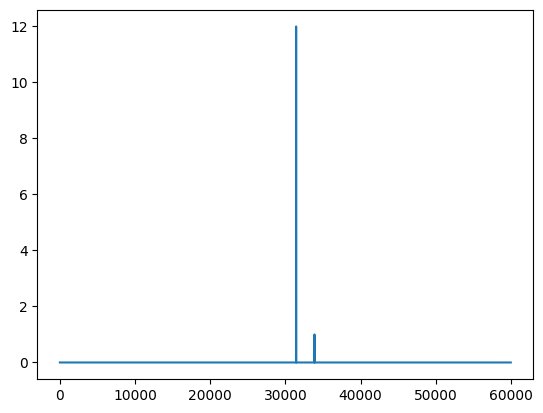

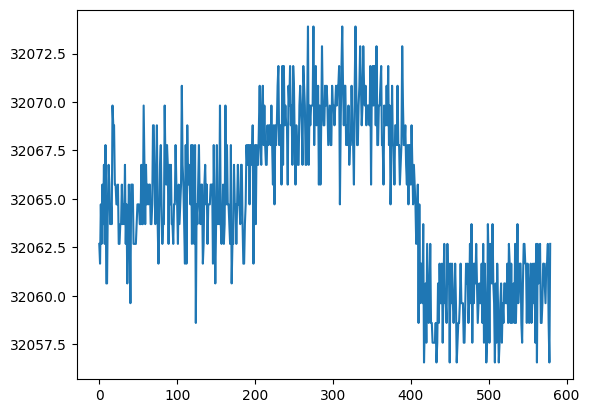

b'Homing X and Y axes.\r\n'
b'X-axis is at the home position.\r\n'
b'Y-axis is goimg to the home position.\r\n'


In [6]:
home_set()


time_array = np.arange(delay,delay*n_acq + delay,delay)
time_delay = []

start_time = time.time()
# time.time() --> has a ~millisecond resolution
y_step(total_distance,stepper_speed)
for i in range(n_acq):
    time_delay.append(hist(t_acq,bin_width,nbins))
    if i%100==0:
        print(i)

    while time.time()<=start_time + time_array[i]:
        continue

time_delay = np.array(time_delay)
plt.plot(time_delay*1e-12*c)
plt.show()
home_step()


step_size2 = 100 #take 100 steps every turn for niter iterations #100/6400 ~ 
niter = nsteps/step_size2
#pseudo
for i in range(niter):
    #take a step right_step(step_size2, stepper_speed)
    # retrieve location
    # if location is what we expect
    # take and save histogram
    # repeat

In [7]:
str(datetime.datetime.now()).replace(" ","_")


'2024-01-15_17:26:12.861764'

In [8]:
np.savetxt(f'Z:/YRF/Experiments/Imaging/Jan_16/{datetime.now()}_{stepper_speed*delay}hres_{np.round(bin_width*c,2)}dres.txt',time_delay)

In [9]:
#what we can try: 

# keep moving it slowly but continuously

#for time in time_array:
# if time.time() > start_time + time:
# time_delay.append(hist(t_acq,bin_width,nbins)) 

#moving slowly: no more problem of effects from acceleration, deceleration

#some other testsb: figure out how well actual speed matches to input speed.


#scan at resolution: 1 every 0.5 seconds, with speed being 64 steps/second -> resolution of 32/6400 * 1cm = very good

In [10]:
home_step()

b'Homing X and Y axes.\r\n'
b'X-axis is at the home position.\r\n'
b'Y-axis is goimg to the home position.\r\n'


In [76]:
def doublestep(x, h1, h2, h3, p1, p2):
    if x<p1:
        return h1
    if x<p2:
        return h2
    return h3
def ds(x,h1, h2, h3, p1, p2):
    y =  np.array(range(len(x)))
    for i in range(len(x)):
        y[i] = doublestep(x[i],h1, h2, h3, p1, p2)
    return y.astype(np.float64)


from scipy import optimize
# plt.plot(np.array(range(len(time_delay))),time_delay)
# plt.plot(ds(np.array(range(len(time_delay))), 32060, 32070, 32050,200,400))

xvals = np.array(range(len(time_delay)))
[(h1, h2, h3, p1, p2), v] = optimize.curve_fit(ds,xvals,time_delay*c*1e-12, p0 = (32065.0,32070.0,32060.0,200.0,400.0))
print(h1, h2, h3, p1, p2)
print(v)
plt.plot(ds(xvals, h1, h2, h3, p1, p2))
plt.plot(time_delay*c*1e-12)

plt.plot(time_delay*c*1e-12)